# DOB Permit Issuance Analysis

*Author: Jiacheng Chen*

*Date: Aug 23, 2023*

In [ ]:
import pkg_resources

installed_packages = [pkg.key for pkg in pkg_resources.working_set]
print(installed_packages)

## Data Preperation

**Read Raw Data**

In [1]:
# Read in raw issuance dataset
import pandas as pd
from sodapy import Socrata

# Identify Opendata NYC Source Domain
client = Socrata("data.cityofnewyork.us","8rVKWjYb75ZgPpouoX7bmtWNL")

# Get Active Major Construction permits through SoQL query

results = client.get_all("ipu4-2q9a", where="job_type = 'NB' OR job_type = 'A1'") # 'results' is a json 
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [2]:
#results_df.to_csv('MajorConstructionDF.csv') # I exported the df to csv for eaiser reuse

>SoQL doesn't support the SUBSTR operator and the dates of the raw data come in as strings. What a pity!

In [3]:
#results_df = pd.read_csv('test.csv')

**Filter `Current Active` Constructions**

In [4]:
# Convert 'dates' in raw df to date type
from datetime import datetime
results_df['expiration_date'] = pd.to_datetime(results_df['expiration_date'], format='mixed', dayfirst=True,  errors='ignore')

In [5]:
results_df.dtypes

borough                                     object
bin__                                       object
house__                                     object
street_name                                 object
job__                                       object
job_doc___                                  object
job_type                                    object
self_cert                                   object
block                                       object
lot                                         object
community_board                             object
zip_code                                    object
bldg_type                                   object
residential                                 object
work_type                                   object
permit_status                               object
filing_status                               object
permit_type                                 object
permit_sequence__                           object
site_fill                      

In [6]:
# Get Current Date
today = datetime.now()

# Get currently active constructions
activeConstruction_df = results_df[results_df['expiration_date'] >= today]

# Format all date columns
# extract date columns from the raw df
dateToChange = results_df.columns[results_df.columns.str.contains('date')].tolist() 

# Convert 'dates' in raw df to date type
activeConstruction_df[dateToChange] = activeConstruction_df[dateToChange].apply(pd.to_datetime)

C:\Users\chenj\AppData\Local\Temp\ipykernel_46868\247517608.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeConstruction_df[dateToChange] = activeConstruction_df[dateToChange].apply(pd.to_datetime)


In [7]:
# Check missing values
activeConstruction_df.isna().sum()

borough                                0
bin__                                  0
house__                                0
street_name                            0
job__                                  0
job_doc___                             0
job_type                               0
self_cert                            384
block                                  0
lot                                    0
community_board                        0
zip_code                               8
bldg_type                              0
residential                         2966
work_type                           6246
permit_status                          1
filing_status                          0
permit_type                            0
permit_sequence__                      0
site_fill                            940
filing_date                            0
issuance_date                        138
expiration_date                        0
job_start_date                         0
permittee_s_firs

## EDA

**Key Metrics Summary**

I chose the categorical variables that don't have significant amount of missing values to be key metrics, such as `job_type`, `permit_type`, `recidential`, `owner's business type`, `non profit`, and I also included `dates` in the table, along with `GIS` variables. 

In [8]:
# Select key columns
activeConstruction_df_summary = activeConstruction_df[['borough','bin__', 'job__', 'job_type', 
                                                       'bldg_type', 'residential','self_cert',
                                                       'permit_type','permit_subtype','permittee_s_license_type',
                                                       'permit_status', 'filing_status', 'owner_s_business_type',
                                                       'permit_si_no',
                                                       'filing_date', 'issuance_date', 'expiration_date',
                                                       'job_start_date','non_profit','gis_latitude', 
                                                       'gis_longitude','gis_council_district']]

In [9]:
# Check and remove duplicates entries that ate exact identical
activeConstruction_df_cleaned = activeConstruction_df_summary[~activeConstruction_df_summary.duplicated(keep='last')]

I noticed there are some entries that a job number matchs mutiple permits and ves versa, but they have different work types or permit types. Considering the complexity of construction works, I decided only remove the rows that are exactly identical. 

*Job Types and Boroughs*

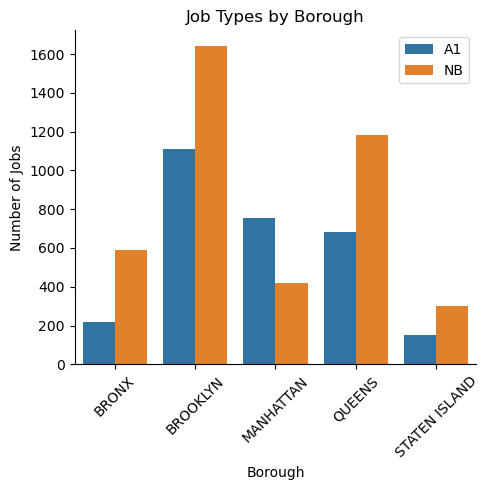

In [11]:
# Group by Borough and Job types, count the number of each job type. 
jobType_sumTable = pd.DataFrame(activeConstruction_df_cleaned.groupby(['borough', 'job_type'])['job__'].count()).reset_index()
jobType_sumTable.columns = ('Borough', 'Job Type', 'Count') # rename columns

# Visualize the Borough Jobtype table
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(data=jobType_sumTable, x='Borough', y='Count', hue='Job Type', kind="bar", legend=False)

# Add labels and title
plt.xlabel("Borough")
plt.xticks(rotation=45)
plt.ylabel("Number of Jobs")
plt.title("Job Types by Borough")
plt.legend()  # Show the legend
plt.tight_layout()

# Save the plot
plt.savefig("job_types_by_borough.png", dpi=300)

In [12]:
# Pivot the table, transform Job Type to columns
jobType_sumTable = jobType_sumTable.pivot(index='Borough', columns='Job Type', values='Count').reset_index()
jobType_sumTable.columns = ['Borough', 'Job Type A1', 'Job Type NB'] # rename columns

# Calculate row and column total Jobs by Boroughs and by Job Types
jobType_sumTable['Total'] = jobType_sumTable['Job Type A1'] + jobType_sumTable['Job Type NB'] # row total
total_row = jobType_sumTable[["Job Type A1", "Job Type NB", "Total"]].sum() # column total
total_row['Borough'] = 'Total'
jobType_sumTable = pd.concat([jobType_sumTable, pd.DataFrame([total_row])], ignore_index=True) # append column total to the table

# Save the Borough_JobType table to excel
import openpyxl
jobType_sumTable.to_excel("job_types_by_borough.xlsx")

In [13]:
jobType_sumTable

,Borough,Job Type A1,Job Type NB,Total
0,BRONX,220,589,809
1,BROOKLYN,1111,1641,2752
2,MANHATTAN,754,421,1175
3,QUEENS,681,1183,1864
4,STATEN ISLAND,150,303,453
5,Total,2916,4137,7053


*Permit Types and Boroughs*

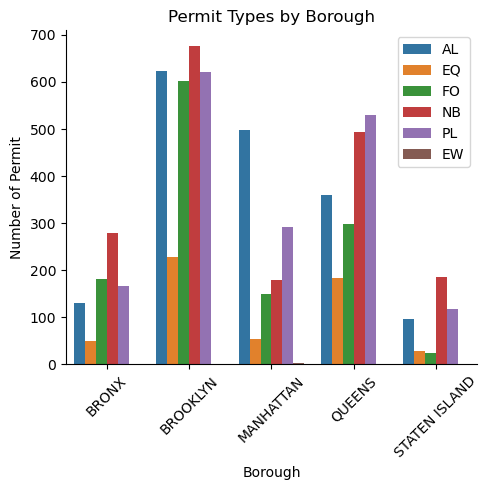

In [14]:
# Group by Borough and Job types, count the number of each job type. 
permitType_sumTable = pd.DataFrame(activeConstruction_df_cleaned.groupby(['borough', 'permit_type'])['job__'].count()).reset_index()
permitType_sumTable.columns = ('Borough', 'Permit Type', 'Count')

# Visualize the Permit Jobtype table
import seaborn as sns
sns.catplot(data=permitType_sumTable, x='Borough', y='Count', hue='Permit Type', kind="bar", legend=False)

# Add labels and title
plt.xlabel("Borough")
plt.xticks(rotation=45)
plt.ylabel("Number of Permit")
plt.title("Permit Types by Borough")
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("permit_types_by_borough.png", dpi=300)

In [15]:
# Pivot the table, transform Permit Type to columns
permitType_sumTable = permitType_sumTable.pivot(index='Borough', columns='Permit Type', values='Count').reset_index()

#replace missing value to 0
permitType_sumTable.fillna(0, inplace=True)

# Calculate row and column total Jobs by Boroughs and by Permit Types
permitType_sumTable['Total'] = permitType_sumTable.iloc[:, 1:].sum(axis=1)# row total
total_row = permitType_sumTable.iloc[:, 1:].sum() # column total
total_row['Borough'] = 'Total'
permitType_sumTable = pd.concat([permitType_sumTable, pd.DataFrame([total_row])], ignore_index=True) # append column total to table

# Save the Borough_JobType table to excel
permitType_sumTable.to_excel("permit_types_by_borough.xlsx")

In [16]:
permitType_sumTable

Permit Type,Borough,AL,EQ,EW,FO,NB,PL,Total
0,BRONX,130.0,50.0,0.0,182.0,280.0,167.0,809.0
1,BROOKLYN,624.0,227.0,0.0,603.0,676.0,622.0,2752.0
2,MANHATTAN,499.0,53.0,2.0,150.0,179.0,292.0,1175.0
3,QUEENS,360.0,183.0,0.0,298.0,494.0,529.0,1864.0
4,STATEN ISLAND,97.0,29.0,0.0,25.0,185.0,117.0,453.0
5,Total,1710.0,542.0,2.0,1258.0,1814.0,1727.0,7053.0


**When the currently active major construction permits issued**

In [17]:
# Numbers of Permit Issuance per day in each borough
TS_issuDate_Boro = activeConstruction_df_cleaned[['borough', 'issuance_date','job__']]
TS_issuDate_Boro = TS_issuDate_Boro.groupby(['borough','issuance_date'])['job__'].count().reset_index(name='issuance_count')

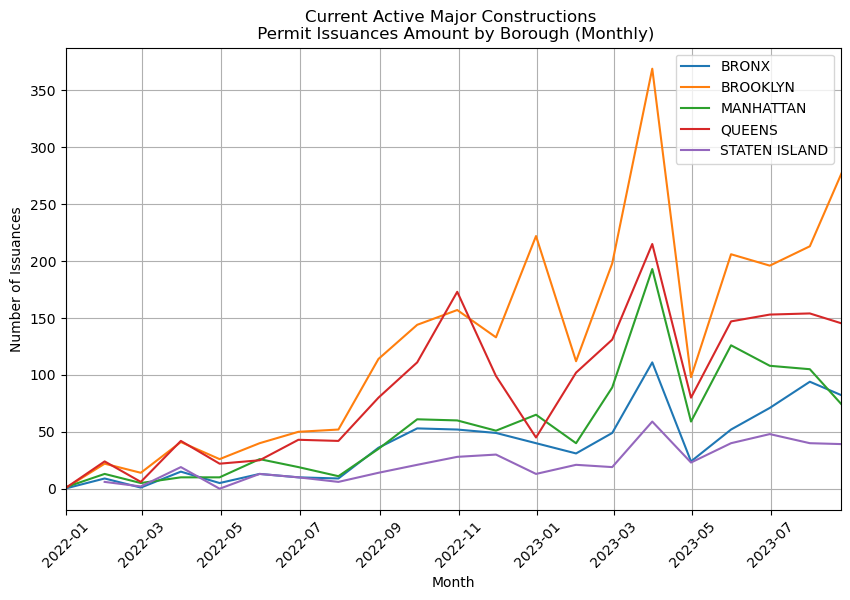

In [22]:
# Time Series Plot
import matplotlib.pyplot as plt # I used matplotlin here cuz it's eaiser to resample the df by different time windows

TS_issuDate_Boro.index = TS_issuDate_Boro['issuance_date']
unique_boroughs = TS_issuDate_Boro['borough'].unique()

plt.figure(figsize=(10, 6))

# Loop through each borough to plot its time series data
for borough in unique_boroughs:
    data = TS_issuDate_Boro[TS_issuDate_Boro['borough'] == borough]['issuance_count']
    data_months = data.resample('M').sum() # Resample to get monthly data
    plt.plot(data_months, label=borough)

# Plot Settings
plt.xlabel('Month')
plt.ylabel('Number of Issuances')
plt.title('Current Active Major Constructions \n Permit Issuances Amount by Borough (Monthly)')
plt.legend()
plt.grid(True)
plt.xlim(pd.Timestamp('2022-01-01'), datetime.now())
plt.xticks(rotation=45) 
plt.savefig('TS_issuanceAmount_boro_monthly.png', dpi = 300)

plt.show()

Most currently active major construction permits were issued within **one year**, with some work begun as early as **January 1, 2022**. 

**Brooklyn** has the highest number of major ongoing construction projects. Notably, the issuance permits in Brooklyn has a peak in January 2023.

There are a few **outliers** that have been under construction since 2006.

In [19]:
# extra long constructions 
# outliars
activeConstruction_df_cleaned[activeConstruction_df_cleaned['issuance_date']<'2022-01-01']

,borough,bin__,job__,job_type,bldg_type,residential,self_cert,permit_type,permit_subtype,permittee_s_license_type,...,owner_s_business_type,permit_si_no,filing_date,issuance_date,expiration_date,job_start_date,non_profit,gis_latitude,gis_longitude,gis_council_district
125568,QUEENS,4619860,410142714,NB,1,YES,N,EQ,FN,GC,...,INDIVIDUAL,3808943,2020-11-24,2020-11-24,2024-05-15,2009-06-17,N,40.760881,-73.735131,19
176724,BRONX,2084295,200737033,A1,1,YES,NaN,AL,NaN,GC,...,INDIVIDUAL,1568767,2002-08-30,2002-09-04,2033-05-17,2002-09-04,N,40.892258,-73.904040,11
744193,BROOKLYN,3243338,321759922,A1,1,YES,N,AL,NaN,GC,...,INDIVIDUAL,3810231,2020-12-01,2020-12-01,2029-12-05,2018-07-13,N,40.610818,-73.905590,46
770467,MANHATTAN,1012003,140964954,A1,2,NaN,N,AL,NaN,GC,...,CORPORATION,3884183,2021-12-07,2021-12-07,2023-11-12,2021-03-03,N,40.735330,-74.009670,3
981349,QUEENS,4085339,401422457,A1,1,YES,Y,PL,NaN,MP,...,INDIVIDUAL,1923646,2006-07-17,2006-07-17,2024-07-18,2002-03-26,N,40.700772,-73.894975,30
981915,MANHATTAN,1813361,177812111,A1,2,YES,N,EQ,FN,GC,...,INDIVIDUAL,3637666,2018-09-25,2018-09-25,2029-09-25,2015-12-02,N,NaN,NaN,NaN
983264,MANHATTAN,1813361,166003042,NB,2,YES,N,NB,NaN,GC,...,CORPORATION,3814034,2020-12-14,2021-01-25,2023-12-13,2021-01-26,N,NaN,NaN,NaN
983723,MANHATTAN,1090608,121192912,NB,2,NaN,N,PL,NaN,MP,...,PARTNERSHIP,1545568,2018-11-21,2018-11-21,2024-05-01,2023-01-05,N,40.761400,-73.966249,4
984119,MANHATTAN,1813248,145147150,A1,2,YES,N,AL,NaN,GC,...,INDIVIDUAL,2182180,2009-11-06,2020-12-14,2024-12-13,2020-12-15,N,NaN,NaN,NaN


In [24]:
import plotly.express as px
fig = px.bar(TS_issuDate_Boro, x='issuance_date', y='issuance_count',color='borough')
fig.update_xaxes(ticks= "outside",
                 ticklabelmode= "period", 
                 tickcolor= "black", 
                 ticklen=10, 
                 minor=dict(
                     ticklen=4,  
                     dtick=7*24*60*60*1000,  
                     tick0="2016-07-03", 
                     griddash='dot', 
                     gridcolor='white'),
                 rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1m", step="month", stepmode="backward"),
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="YTD", step="year", stepmode="todate"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(step="all")])
                     )
                )
fig.show()

# Code based on the example from Plotly at https://plotly.com/python/time-series/#adding-minor-ticks

Here is an interactive bar plot that provides a comprehensive view of when the permits of active major constructions issued. This includes projects that were issued permits before January 1, 2022.

**Active major constrction sites**

In [26]:
import geopandas as gpd

# Convert the working df to gdf
activeConstruction_gdf = gpd.GeoDataFrame(activeConstruction_df_cleaned, 
                                          geometry=gpd.points_from_xy(activeConstruction_df_cleaned.gis_longitude, activeConstruction_df_cleaned.gis_latitude))
# Set crs to 4326
activeConstruction_gdf.crs = 4326

<Axes: >

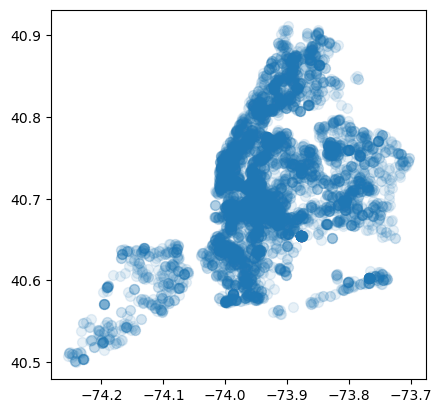

In [27]:
# Plot the points
activeConstruction_gdf.plot(alpha=0.1, markersize=50)

**Spatial Join with Business Improvement Districts**

BetaNYC has a very practical project that showcases various administrative boundaries in NYC. I found it would be interesting to explore Business Improvement Districts in context with major construction projects.

BetaNYC NYC Boundaries Map: https://beta.nyc/products/boundaries-map/

In [28]:
# read in BID geojson
bid_url = "https://data.cityofnewyork.us/resource/7jdm-inj8.geojson"
bid_gdf = gpd.read_file(bid_url)

<Axes: >

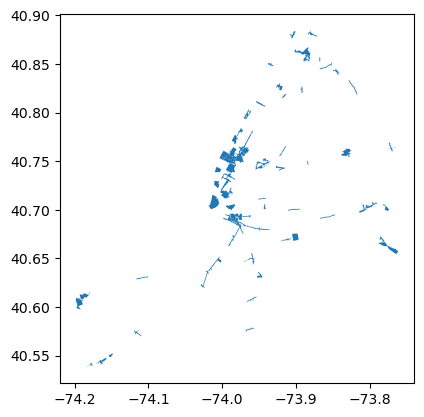

In [29]:
bid_gdf.plot()

(-74.2820442, -73.67541179999999, 40.4787234, 40.9315846)

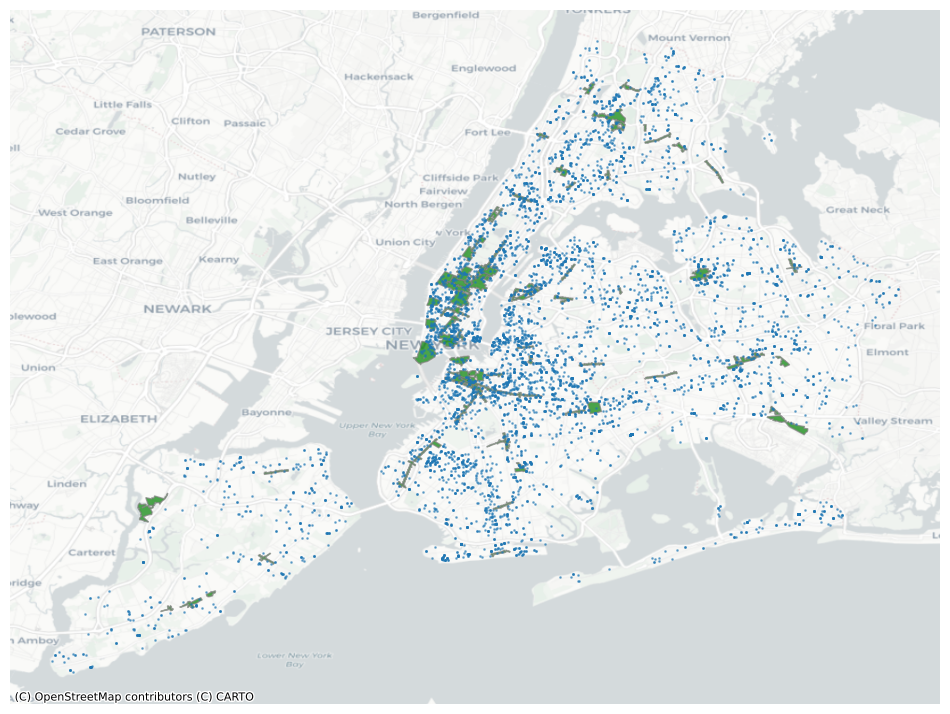

In [31]:
# Add bid and active construction layers to map 
fig, bid_ac_ax= plt.subplots(figsize=(12,12))

# layer settings
bid_gdf.plot(alpha = 0.7, edgecolor = 'gray', color = 'green', ax=bid_ac_ax)
activeConstruction_gdf.plot(alpha = 0.5, markersize = 1, ax=bid_ac_ax)

# add a basemap
import contextily as cx
basemap = cx.providers.CartoDB.Positron
cx.add_basemap(bid_ac_ax, crs = 4326, source=basemap)

bid_ac_ax.axis('off')

In [32]:
bid_gdf.head()

,bidid,shape_area,modified,bid,borough,created,shape_len,geometry
0,51,1939382.7032,2019-10-16,Flatbush-Nostrand Junction BID,Brooklyn,2016-09-12,10101.1543192,"MULTIPOLYGON (((-73.95016 40.63603, -73.95013 ..."
1,17,1660014.21456,2016-10-25,125th Street BID,Manhattan,2008-11-19,12038.2719209,"MULTIPOLYGON (((-73.94216 40.80684, -73.94200 ..."
2,52,1838845.29605,2019-10-16,Bay Ridge 5th Avenue BID,Brooklyn,2016-09-28,18054.6900828,"MULTIPOLYGON (((-74.01998 40.63472, -74.02002 ..."
3,46,389826.922437,2016-10-20,82nd Street BID,Queens,2008-11-19,4335.74722401,"MULTIPOLYGON (((-73.88385 40.74989, -73.88385 ..."
4,67,5376842.08178,2019-10-16,Hudson Yards/Hell's Kitchen,Manhattan,2016-11-01,14220.4256124,"MULTIPOLYGON (((-74.00002 40.75339, -74.00053 ..."


In [33]:
# Spatial Join bid polygon geom to the point dataset
joined_layer_bid_ac = gpd.sjoin(activeConstruction_gdf, bid_gdf[['bid', 'geometry']], how="right", predicate='within')

# Group by and count number of points in bid polygons
joined_layer_bid_ac_count = gpd.GeoDataFrame(joined_layer_bid_ac.groupby(['bid','geometry']).size().reset_index(name = 'Count'))

<Figure size 1200x1200 with 0 Axes>

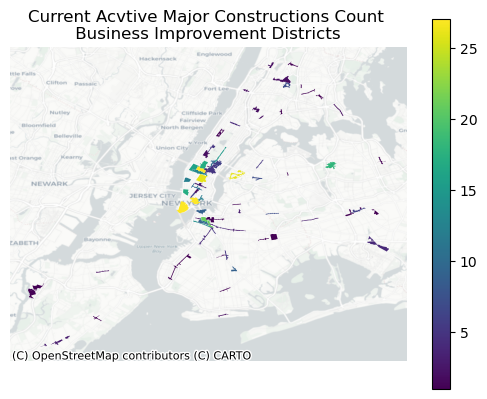

In [34]:
# plot the amount of active major constructions by bid
plt.figure(figsize=(12,12))

# layer setting
joined_bid_ac_ax = joined_layer_bid_ac_count.plot(column='Count', legend=True)

# add basemap
cx.add_basemap(joined_bid_ac_ax, crs = 4326, source=basemap)

# title and other settings
plt.title('Current Acvtive Major Constructions Count \n Business Improvement Districts ')
joined_bid_ac_ax.axis('off')

# save the output
plt.savefig('bid_activeMajorCons_map.png',dpi=300)

In [35]:
# interactive map to navigate better
joined_layer_bid_ac_count.explore(column='Count', legend=True)

In [36]:
# Identify Business Improvement Districts that have more than 20 active major constructions. 
joined_layer_bid_ac_count[joined_layer_bid_ac_count['Count']>=20].sort_values(by='Count')

,bid,geometry,Count
51,MetroTech BID,"MULTIPOLYGON (((-73.98453 40.69604, -73.98453 ...",21
29,Flatiron/23rd Street Partnership,"MULTIPOLYGON (((-73.99292 40.74374, -73.99287 ...",26
47,Long Island City,"MULTIPOLYGON (((-73.94008 40.74883, -73.94000 ...",26
17,Chinatown,"MULTIPOLYGON (((-73.99191 40.71724, -73.99183 ...",27
23,Downtown Alliance BID,"MULTIPOLYGON (((-74.01418 40.70059, -74.01419 ...",27
34,Garment District,"MULTIPOLYGON (((-73.99307 40.75783, -73.99263 ...",27


In terms of New York City's business improvement districts, lower and midtown Manhattan are very busy with construction. Downtown Brooklyn has some as well. And I'm happy to see more constructions in LIC and Flushing because that suggests community vibrancy and business development. The increase in construction activity indicates positive growth and opportunity in these areas.

In [37]:
# export the gdf to excel
joined_layer_bid_ac.to_excel('Bid_ActiveMajorContruction.xlsx', index = False)

In [38]:
# convert date variables to string before exporting to shp file

# save date columns to a list
dateToStr = joined_layer_bid_ac.columns[joined_layer_bid_ac.columns.str.contains('date')].tolist() 
# for each column, convert datetime to date string
for column in dateToStr:
    joined_layer_bid_ac[column] = joined_layer_bid_ac[column].dt.strftime('%Y-%m-%d')

In [39]:
# export layer to shp 
joined_layer_bid_ac.to_file('bid_ActiveMajorConstruction.shp')

C:\Users\chenj\AppData\Local\Temp\ipykernel_46868\2762757711.py:2: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



## Spatial Autocorrelation

I decided to conduct a Spatial Aitocorrelation analysis to determine whether clusters of active construction projects exist. My goal is to identify where the clusters are and to compare them with the Business Improvement Districts map. To achieve this, I employed Moran's Index. 

**Prepare the basemap**

In [40]:
import numpy as np
import shapely

def make_grid(gdf, n_cells):
    gdf = gdf.copy()
    xmin, ymin, xmax, ymax= gdf.total_bounds
    cell_size = (xmax-xmin)/n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)
    return grid

# code based on lecture note from WIll Geary at https://github.com/willgeary/info615/blob/main/modules/09-spatial-point-patterns/notebook.ipynb 

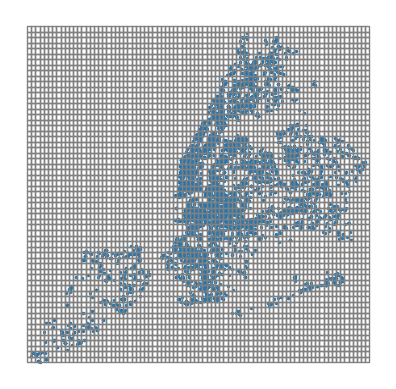

In [41]:
# genarate a grid over map
grid = make_grid(activeConstruction_gdf, n_cells=80)

# overlap the points with grid
ax = activeConstruction_gdf.plot(markersize=2)
grid.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
ax.axis('off');

In [42]:
# to aggregate and summarize points over grid
def rasterize(gdf, grid, aggfunc="count", column=None, plot=True):
    merged = gpd.sjoin(gdf, grid, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column
        merged[column] = 1
    else:
        output_col = column + "_" + aggfunc   
    dissolved = merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns = [output_col]
    grid.loc[dissolved.index, output_col] = dissolved[output_col].values
    if plot:
        ax = grid.plot(column=output_col, figsize=(12, 8), edgecolor="grey", legend=True)
        ax.axis('off')
        cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf.crs)
        plt.show()
    return grid

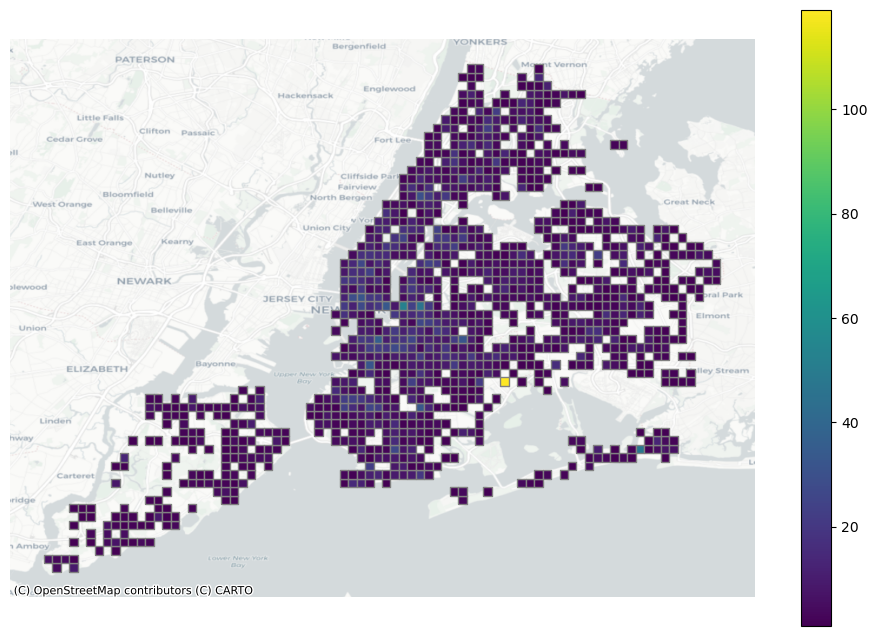

In [43]:
r = rasterize(activeConstruction_gdf, grid, aggfunc="count", plot=True)

In [44]:
# drop grid cells contain no points
r = r.dropna(subset=['count'])

**Global Moran's I**

In [45]:
# build a spatial weights matrix
from pysal.lib import weights

# Use Queen contiguity to generate weights
w = weights.Queen.from_dataframe(r)
# row-standardized weight matrix
w.transform = 'R'

w.weights

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\libpysal\cg\alpha_shapes.py:198: NumbaD

('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 74, ' is an island (no neighbors)')
('WARNING: ', 684, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')


c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 6 islands with ids: 6, 23, 35, 74, 684, 891.



{0: [0.5, 0.5],
 1: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 2: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 3: [0.25, 0.25, 0.25, 0.25],
 4: [0.5, 0.5],
 5: [0.5, 0.5],
 6: [],
 7: [1.0],
 8: [0.5, 0.5],
 9: [0.2, 0.2, 0.2, 0.2, 0.2],
 10: [0.25, 0.25, 0.25, 0.25],
 11: [0.5, 0.5],
 12: [1.0],
 13: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 14: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 15: [0.5, 0.5],
 16: [0.25, 0.25, 0.25, 0.25],
 17: [0.25, 0.25, 0.25, 0.25],
 18: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 19: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 20: [0.2, 0.2, 0.2, 0.2, 0.2],
 21: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 22: [0.2, 0.2, 0.2, 0.2, 0.2],
 23: [],
 24: [0.5, 0.5],
 25: [0.25, 0.25, 0.25, 0.25],
 26: [0.16666666666666666,
  0.16666666666666666,
  0

In [46]:
# Global spatial autocorrelation hypothesis test
from pysal.explore import esda

# H0: There is no spatial autocorrelation 
# Ha: There no spatial autocorrelation 
moran = esda.moran.Moran(r['count'], w, permutations=9999)

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning:

numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\quantecon\lss.py:19: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\spaghetti\network.py:40: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first 

In [47]:
moran.I

0.2407861172612453

In [48]:
moran.p_sim

0.0001

The simulated p-value is very low. We are confident to reject the null hypothesis and conclude that spatial autocorrelation is in fact present. 

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.24', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.24)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

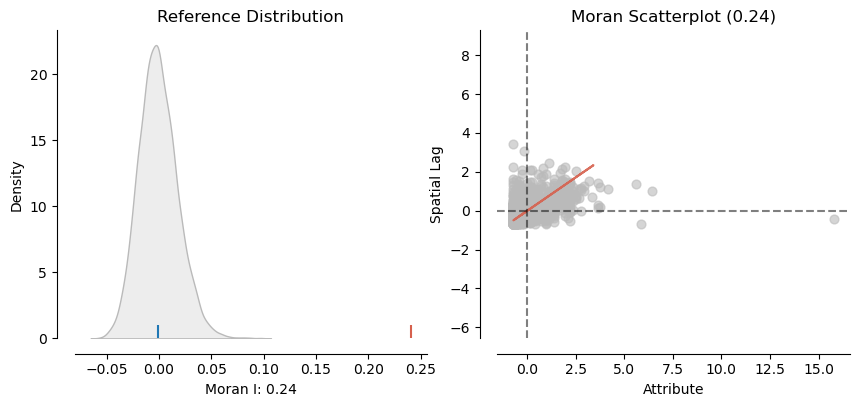

In [49]:
# plot the Global Moran's I results
from splot.esda import plot_moran
plot_moran(moran)

**Local Moran's I**

In [50]:
# test for local spatial autocorrelation
local_moran = esda.moran.Moran_Local(r['count'], w) # use the same wright matrix

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

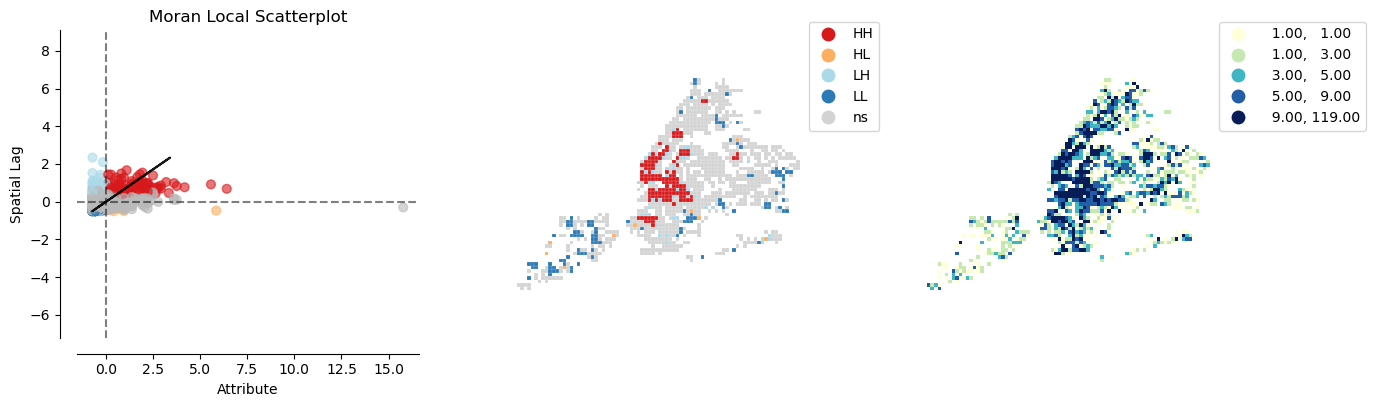

In [51]:
# plot local moran's I results
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(local_moran, r, 'count', p=0.05)

**Compare with Business Improvement Districts**

In [52]:
r['local_moran_Is'] = local_moran.Is
r['local_moran_p_value'] = local_moran.p_sim
r['local_moran_quadrant'] = local_moran.q

alpha = 0.05
hotspots = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\chenj\miniconda3\envs\gisenv\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

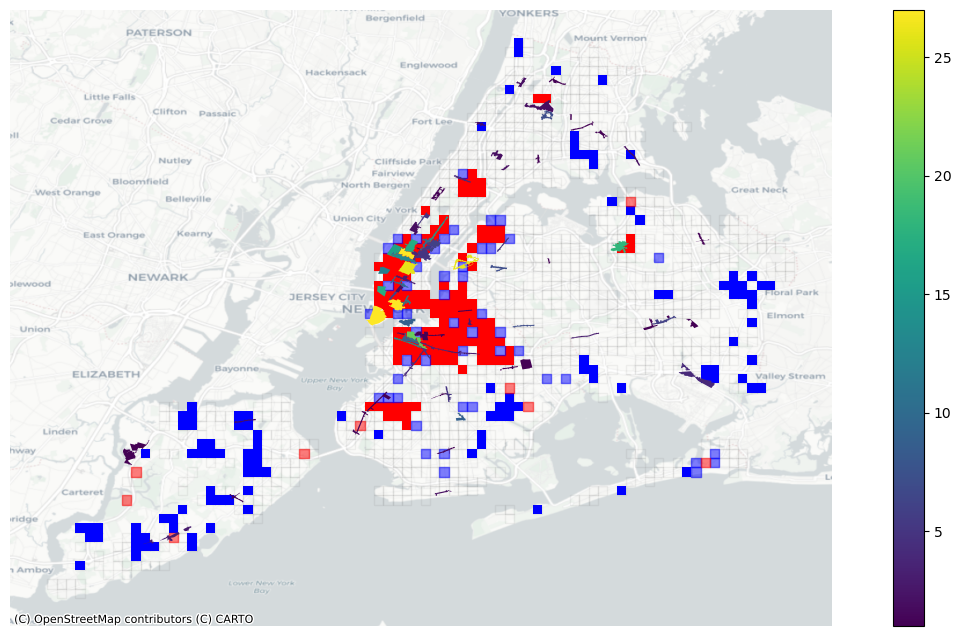

In [56]:
fig, cluster_map = plt.subplots(figsize = (16,8))
r.plot(ax=cluster_map, facecolor='none', alpha=0.05)
hotspots.plot(color='red', ax=cluster_map, label='Hot Spot')
coldspots.plot(color='blue', ax=cluster_map, label='Cold Spot')
doughnuts.plot(color='blue', ax=cluster_map, label='Doughnuts', alpha=0.5, edgecolor='blue')
diamonds.plot(color='red', ax=cluster_map, label='Diamonds',alpha=0.5, edgecolor='red')

joined_layer_bid_ac_count.plot(column='Count', legend=True, ax=cluster_map)
cluster_map.axis('off')
cx.add_basemap(cluster_map, crs = 4326, source=basemap)


The tessellation grids appear to be too large compare to the bid boundries. However, we can generally tell there are overlaps between the hot spots and the business improvement districts.